In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from navigation_game import NavigableNetwork
import scipy
import numpy as np
from vizman import viz
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from numba import prange


In [111]:
from scipy.stats import ks_2samp
from scipy.spatial.distance import pdist, squareform

def evaluator(synthetic, empirical, euclidean_distance):
    degrees_synthetic = np.sum(synthetic, axis=0)
    degrees_empirical = np.sum(empirical, axis=0)
    ks_degree = ks_2samp(degrees_synthetic, degrees_empirical)
    
    clustering_synthetic = nx.clustering(nx.from_numpy_array(synthetic))
    clustering_empirical = nx.clustering(nx.from_numpy_array(empirical))
    ks_clustering = ks_2samp(list(clustering_synthetic.values()), list(clustering_empirical.values()))
    
    betweenness_synthetic = nx.betweenness_centrality(nx.from_numpy_array(synthetic))
    betweenness_empirical = nx.betweenness_centrality(nx.from_numpy_array(empirical))
    ks_betweenness = ks_2samp(list(betweenness_synthetic.values()), list(betweenness_empirical.values()))
    
    distance_synthetic = euclidean_distance[np.triu(synthetic, 1) > 0]
    distance_empirical = euclidean_distance[np.triu(empirical, 1) > 0]
    ks_distance = ks_2samp(distance_synthetic, distance_empirical)
    
    return np.max([ks_degree[0], ks_clustering[0], ks_betweenness[0], ks_distance[0]])

In [4]:
viz.set_visual_style()
default_sizes = viz.load_data_from_json("sizes.json")
default_colors = viz.load_data_from_json("colors.json")
default_cmaps = viz.give_colormaps()

In [91]:
default_sizes

{'small': [5, 3],
 'half_column': [9, 5],
 'wide': [18, 9],
 'half_page': [18, 12],
 'full_page': [18, 16]}

In [5]:
default_cmaps

{'db_bw_lr': <matplotlib.colors.LinearSegmentedColormap at 0x1320e5f50>,
 'nb_bw_dr': <matplotlib.colors.LinearSegmentedColormap at 0x132362010>,
 'sg_bw_pi': <matplotlib.colors.LinearSegmentedColormap at 0x125aed850>,
 'bw_lr': <matplotlib.colors.LinearSegmentedColormap at 0x131d2ad10>,
 'bw_db': <matplotlib.colors.LinearSegmentedColormap at 0x132363b10>,
 'bw_hb': <matplotlib.colors.LinearSegmentedColormap at 0x1322eea10>}

In [6]:
# Create test coordinates matching the paper's example
coords = np.array([
    [1, 1],  # A
    [3, 1],  # B
    [3, 2],  # C
    [1, 5],  # D
])

# Create network and get equilibrium
net = NavigableNetwork(coords)
equilibrium = net.build_nash_equilibrium()

# Print the adjacency matrix
print("Adjacency matrix:")
print(equilibrium.astype(int))


Adjacency matrix:
[[0 0 1 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]


<Axes: >

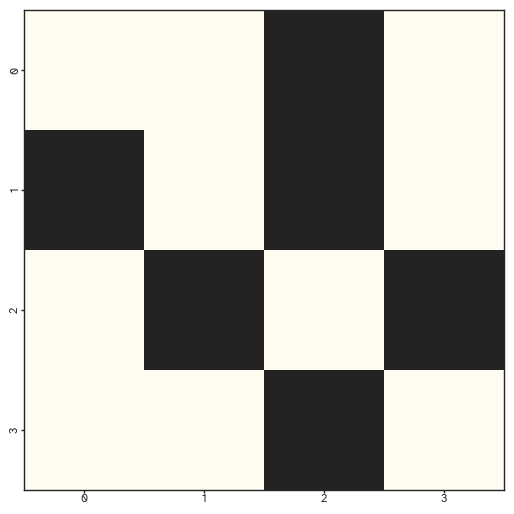

In [7]:
viz.plot_matrix(equilibrium, sns_kwargs={"cmap":default_cmaps["bw_hb"]})

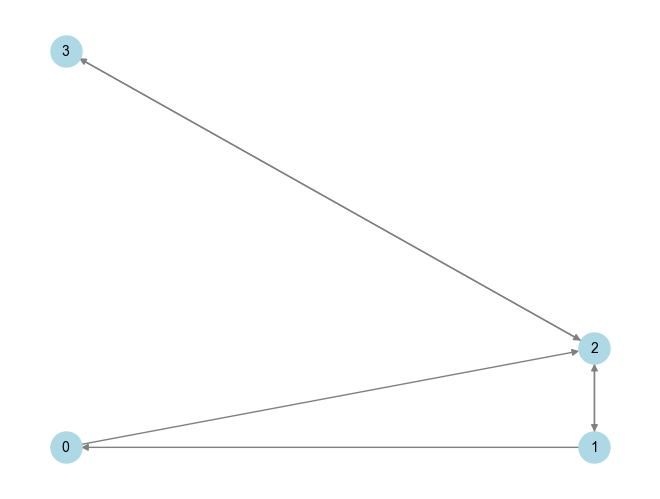

In [8]:
import networkx as nx

G = nx.from_numpy_array(equilibrium, create_using=nx.DiGraph)

# Extract positions of nodes
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
nx.draw(G, pos = coords, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black', edge_color='gray')

In [143]:
res_parcellation = 0
consensus_mat = scipy.io.loadmat(
    "datasets/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]
euclidean_dis = squareform(pdist(coordinates, metric='euclidean'))


In [10]:
game = NavigableNetwork(coordinates)
nash_network = game.build_nash_equilibrium()

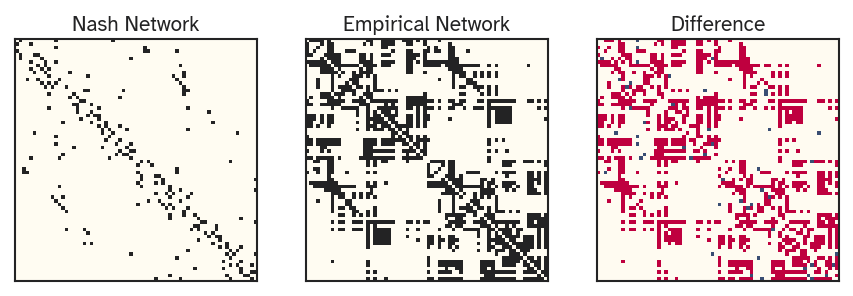

In [11]:
fig, axes = plt.subplot_mosaic([["A", "B","C"]], figsize=viz.cm_to_inch(default_sizes['half_page']), dpi=150)
viz.plot_matrix(nash_network.astype(int), axis=axes["A"], sns_kwargs={"cmap":default_cmaps["bw_hb"], 
                                                                      "xticklabels":False, "yticklabels":False})
viz.plot_matrix(connectivity.astype(int), axis=axes["B"], sns_kwargs={"cmap":default_cmaps["bw_hb"], 
                                                                      "xticklabels":False, "yticklabels":False})
viz.plot_matrix(connectivity.astype(int)-nash_network.astype(int), axis=axes["C"], sns_kwargs={"cmap":default_cmaps["nb_bw_dr"], 
                                                                                               "xticklabels":False, "yticklabels":False})
axes["A"].set_title("Nash Network")
axes["B"].set_title("Empirical Network")
axes["C"].set_title("Difference");

Evaluating network evolution: 100%|██████████| 3000/3000 [02:12<00:00, 22.57it/s]


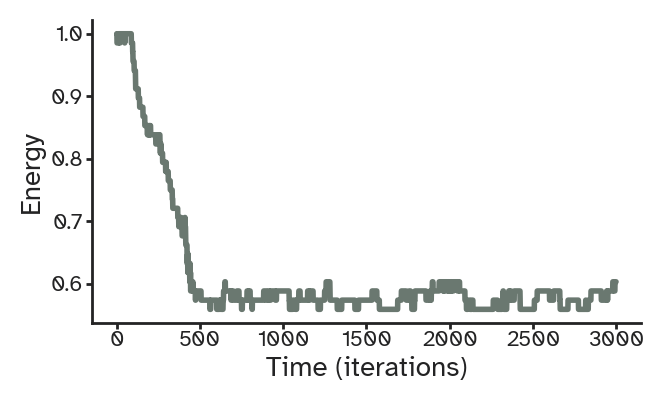

In [144]:
from navigation_game import NetworkParameters, DevelopingNetwork, SimulationMode
from tqdm import tqdm

# Create parameters
# params = NetworkParameters(
#     alpha=1.0,
#     beta_infinity=1.0,
#     tau_beta=50.0,
#     t0=1.0,
#     tau_t=50.0,
#     connectivity_penalty=100.0,
#     n_flips_per_iteration=10,
#     seed=42
# )

fixed_params = NetworkParameters(
    mode=SimulationMode.FIXED,
    alpha=150.0,
    beta=0.1,
    temperature=0.1,
    connectivity_penalty=100
)
# Create network
network = DevelopingNetwork(coordinates, fixed_params)

# Run simulation
adjacency_history = network.simulate(n_iterations=3_000)
fit_vector = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    fit_vector[t] = evaluator(adjacency_history[:,:,t], connectivity, euclidean_dis)

plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(fit_vector,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Energy")
sns.despine()

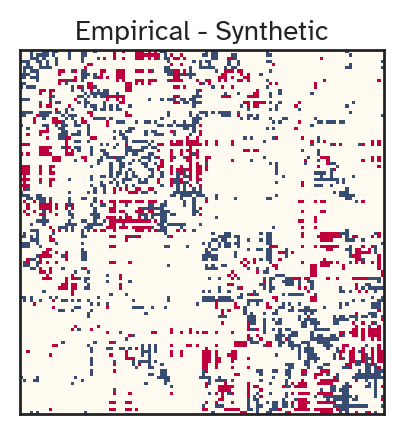

In [121]:
best_fit_matrix = adjacency_history[:,:,np.argmin(fit_vector)]
plt.figure(figsize=viz.cm_to_inch((6,6)), dpi=200)
ax = plt.subplot(111)
viz.plot_matrix(connectivity-best_fit_matrix, sns_kwargs={"cmap":default_cmaps["nb_bw_dr"], 
                                                          "xticklabels":False, 
                                                          "yticklabels":False}, axis=ax)
plt.title("Empirical - Synthetic");

In [142]:
connectivity.shape

(114, 114)

In [152]:
from navigation_game import ParameterSpace, NetworkFitter, SimulationMode

param_space = ParameterSpace(
    param_ranges={
        'alpha': (100.0, 200.0),
        'beta': (0.01, 1),
        'temperature': (0.01, 1),
    },
    fixed_params={
        'connectivity_penalty': 100.0,
    }
)

fitter = NetworkFitter(
    coordinates=coordinates,
    empirical_adj=connectivity,
    parameter_space=param_space,
    mode=SimulationMode.FIXED,
    n_trials=20,
    n_iterations=500,
)

results = fitter.fit()

Fitting parameters: 100%|██████████| 20/20 [06:45<00:00, 20.26s/it]


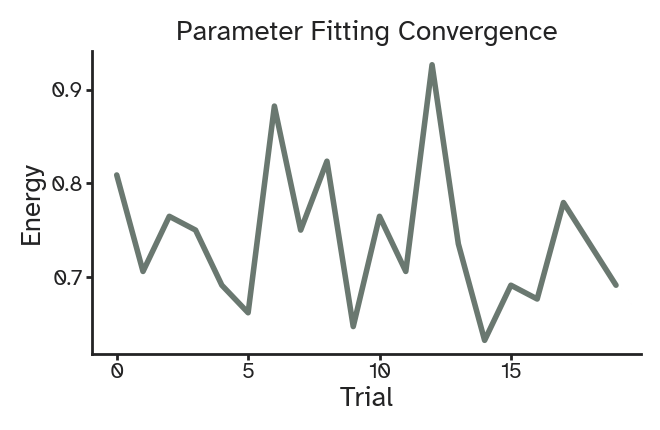

In [153]:
plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(results.all_scores,lw=2)
plt.xlabel('Trial')
plt.ylabel('Energy')
plt.title('Parameter Fitting Convergence')
sns.despine()

In [154]:
results.best_params

{'alpha': 200.0,
 'beta': 0.2645727351537472,
 'temperature': 0.3776430618984195,
 'connectivity_penalty': 100.0}

In [155]:
results.best_score

0.6323529411764706

Evaluating network evolution: 100%|██████████| 3000/3000 [05:43<00:00,  8.74it/s]


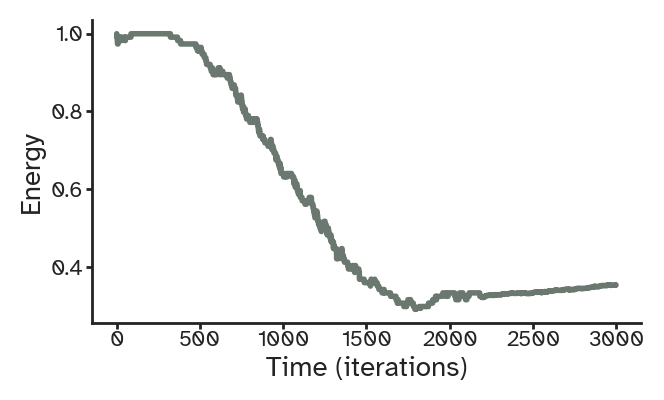

In [139]:
fixed_params = NetworkParameters(
    mode=SimulationMode.FIXED,
    alpha=results.best_params['alpha'],
    beta=0.1,
    temperature=0.1,
    connectivity_penalty=100
)
# Create network
network = DevelopingNetwork(coordinates, fixed_params)

# Run simulation
adjacency_history = network.simulate(n_iterations=3_000)
fit_vector = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    fit_vector[t] = evaluator(adjacency_history[:,:,t], connectivity, euclidean_dis)

plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(fit_vector,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Energy")
sns.despine()

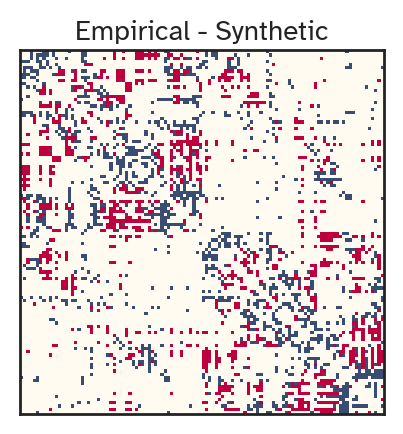

In [141]:
best_fit_matrix = adjacency_history[:,:,np.argmin(fit_vector)]
plt.figure(figsize=viz.cm_to_inch((6,6)), dpi=200)
ax = plt.subplot(111)
viz.plot_matrix(connectivity-best_fit_matrix, sns_kwargs={"cmap":default_cmaps["nb_bw_dr"], 
                                                          "xticklabels":False, 
                                                          "yticklabels":False}, axis=ax)
plt.title("Empirical - Synthetic");

In [109]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from numpy.typing import NDArray
from typing import Optional

def animate_network_evolution(coordinates: NDArray[np.float64], 
                            adjacency_history: NDArray[np.int8],
                            interval: int = 50,
                            save_path: Optional[str] = None) -> FuncAnimation:
    """
    Create an animation of network evolution over time.
    
    Args:
        coordinates: Array of shape (n_nodes, 2) containing node coordinates
        adjacency_history: Array of shape (n_nodes, n_nodes, n_timesteps) 
                         containing adjacency matrices at each timestep
        interval: Time between frames in milliseconds
        save_path: Optional path to save animation (e.g., "animation.gif")
    
    Returns:
        matplotlib.animation.FuncAnimation object
    """
    # Setup the figure
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    
    # Create networkx graph
    G = nx.Graph()
    G.add_nodes_from(range(len(coordinates)))
    pos = {i: coordinates[i] for i in range(len(coordinates))}
    
    # Initialize plot elements
    node_collection = nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                                           node_size=300, ax=ax)
    edge_collection = nx.draw_networkx_edges(G, pos, ax=ax)
    time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes,
                       fontsize=12, ha='left', va='top')
    
    # Set animation properties
    node_collection.set_animated(True)
    time_text.set_animated(True)
    
    def update(frame):
        """Update animation for each frame"""
        # Clear current edges
        if len(ax.collections) > 1:
            ax.collections[1].remove()
        
        # Get current adjacency matrix
        adj = adjacency_history[:, :, frame]
        
        # Update edges
        edge_list = [(i, j) for i in range(len(adj)) 
                    for j in range(i+1, len(adj)) if adj[i,j]]
        G.clear_edges()
        G.add_edges_from(edge_list)
        
        # Draw new edges
        edge_collection = nx.draw_networkx_edges(G, pos, ax=ax)
        
        # Update timestep text
        time_text.set_text(f'Timestep: {frame}')
        
        return node_collection, edge_collection, time_text
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=adjacency_history.shape[2],
                        interval=interval)
    
    # Save if path provided
    if save_path:
        anim.save(save_path, writer='pillow')
    
    plt.close()
    return anim

In [110]:
anim = animate_network_evolution(coordinates[:, :2], adjacency_history, save_path='network_evolution.gif')